# NLP: Análisis de Sentimientos con VADER y RoBERTa
Análisis aplicado a descripciones de libros en español.

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Cargar datos
file_path = "../data/processed/books.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace(".", "_").str.replace(":", "")
df = df[["blurb", "tags", "book_title"]].dropna(subset=["blurb"]).head(500)
df.head()

,blurb,tags,book_title
0,"Walter Ciszek, jesuita norteamericano, entró e...","abandonment-in-god, biography, catholic, chełm...",Caminando por valles oscuros: Memorias de un j...
1,<p>A chance encounter with a reproduction of R...,"_pilar, _sindy, abandonment-in-god, anxiety, a...",The Return of the Prodigal Son: A Story of Hom...
2,"A pesar de nuestros mejores esfuerzos, muchos ...","catholic, chełmińska, christ, christianity, de...",Liberado: Una Guía Práctica para la Liberación
3,Esta breve obra se compone de cartas escritas ...,"abandonment-in-god, catholic, christ, classics...",El Abandono en la Divina Providencia: Clásicos...
4,Resulta difícil no emocionarse varias veces al...,"adventures, atheism, biography, catholic, chur...",Una familia de bandidos en 1793


## Preprocesamiento NLP: Tokenización con NLTK

In [3]:
import nltk
from nltk.tokenize import PunktSentenceTokenizer, TreebankWordTokenizer
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("vader_lexicon")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jesus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
tokenizer_sent = PunktSentenceTokenizer()
tokenizer_words = TreebankWordTokenizer()
example = df["blurb"].iloc[65]
sentences = tokenizer_sent.tokenize(example)
tokens = []
for sentence in sentences:
    tokens.extend(tokenizer_words.tokenize(sentence))
print(tokens)
print(nltk.pos_tag(tokens))

['St', 'John', 'of', 'the', 'Cross', 'testifies', 'to', 'a', 'God', 'who', 'longs', 'to', 'meet', 'us', 'in', 'our', 'deepest', 'need', '.', 'Whilst', 'rejection', 'and', 'imprisonment', 'played', 'their', 'part', 'in', 'the', 'life', 'of', 'this', 'sixteenth-century', 'Spanish', 'friar', ',', 'John', "'s", 'poetry', 'and', 'prose', 'reveal', 'the', 'beauty', 'and', 'power', 'of', 'a', 'wondrous', 'God', '.', 'It', 'gives', 'us', 'courage', 'to', 'believe', 'in', 'the', 'possibility', 'of', 'change', 'in', 'our', 'own', 'lives', ',', 'however', 'unlikely', 'or', 'impossible', 'this', 'may', 'seem.', '<', 'br', '/', '>', 'Father', 'Iain', 'Matthew', 'uses', 'this', 'classic', 'inspirational', 'Christian', 'writing', 'as', 'his', 'starting', 'point', ',', 'and', 'offers', 'five', 'interpretations', 'which', 'make', 'its', 'richness', 'relevant', 'to', 'the', 'modern', 'reader', '.']
[('St', 'NNP'), ('John', 'NNP'), ('of', 'IN'), ('the', 'DT'), ('Cross', 'NNP'), ('testifies', 'NNS'), ('to

## Análisis de Sentimientos con VADER

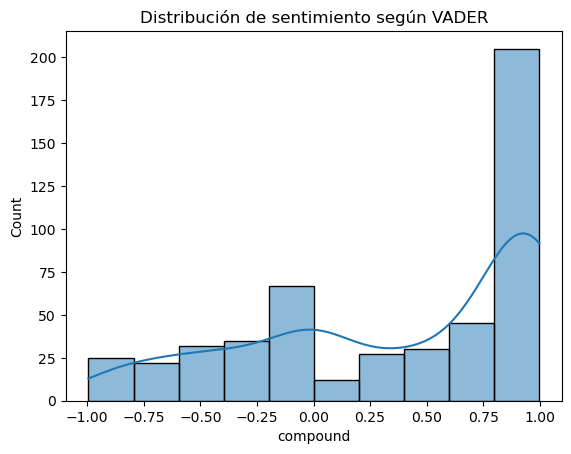

In [5]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
pol_scores = {}
for i, row in df.iterrows():
    text = row["blurb"]
    scores = sia.polarity_scores(text)
    pol_scores[i] = scores
vaders = pd.DataFrame(pol_scores).T
vaders = pd.concat([df.reset_index(drop=True), vaders.reset_index(drop=True)], axis=1)
sns.histplot(vaders["compound"], kde=True)
plt.title("Distribución de sentimiento según VADER")
plt.show()

## Análisis de Sentimientos con RoBERTa (inglés)

In [6]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
MODEL = "j-hartmann/emotion-english-distilroberta-base"
classifier = pipeline("text-classification", model=MODEL, return_all_scores=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Device set to use cpu


In [7]:
def mooder(text):
    max_len = 512
    encoded = tokenizer(text, return_tensors="pt", max_length=max_len, truncation=True, padding="max_length")
    with torch.no_grad():
        output = model(**encoded)
    scores = output.logits[0].numpy()
    return {
        "anger": scores[0], "disgust": scores[1], "fear": scores[2],
        "joy": scores[3], "neutral": scores[4], "sadness": scores[5],
        "surprise": scores[6]
    }

In [8]:
roberta = df["blurb"].apply(mooder)
roberta_df = pd.DataFrame(roberta.tolist())
moods = pd.concat([df.reset_index(drop=True), roberta_df.reset_index(drop=True)], axis=1)
moods.sample(10)

,blurb,tags,book_title,anger,disgust,fear,joy,neutral,sadness,surprise
278,A study of the primordial figure of the Great ...,"anthropology, feminism, history, mithology, no...",The Great Goddess: Reverence of the Divine Fem...,-0.960895,0.608931,-1.185412,-0.633961,4.099282,-1.218097,-0.166826
391,"When it was first published in 1947, <i>The Ag...","anxiety, award-winning, classics, fiction, mie...",The Age of Anxiety: A Baroque Eclogue,1.099704,-0.361477,1.936136,-1.136275,-0.687973,0.222533,-1.317374
12,Un clásico sobre el amor humano entendido como...,"anthropology, catholic, chastity, classics, co...",Amor y responsabilidad,0.200856,0.795680,0.364669,-2.057616,2.181098,-1.239987,-0.122580
231,"""From the rising of the sun to its setting my ...","bible, catholic, church-history, eucharist, id...",The Eucharist Foretold: The Lost Prophecy of M...,4.024282,1.864428,0.153582,-1.668773,0.312886,-1.743630,-2.079754
498,This classic of world spiritual literature is ...,"004-ladder-long-term, christianity, devotional...",The Way of a Pilgrim and The Pilgrim Continues...,-1.701516,-0.714975,2.790184,-0.255517,2.012324,-0.333133,-2.006198
330,"A Roman soldier, Marcellus, wins Christ's robe...","004-ladder-long-term, christ, christianity, ch...",The Robe,-1.609060,-1.222704,-1.682171,2.102669,3.867398,-0.476882,-0.012869
148,The story of the icon of Our Mother of Perpetu...,"art-history, christianity, devotional, miex, n...","The Story of an Icon: The Full History, Tradit...",-1.416256,0.868883,-2.095813,1.766466,3.675557,-1.324131,-0.618410
183,"In this definitive biography, renowned Bible s...","audiobooks, biography, christianity, faith, hi...",Paul: A Biography,-0.298899,-0.248438,-0.073704,-0.473278,2.593453,-1.246022,0.343734
256,"How to Read a Book, originally published in 19...","books, classics, education, nonfiction, philos...",How to Read a Book,0.226821,-0.327800,-1.805496,-0.173389,3.782158,-1.392857,0.581580
484,<i>\r\n <pre>This is a previously-published e...,"_sindy, adolescence, bestseller, fantasy, fict...",Harry Potter y la piedra filosofal (Harry Pott...,-0.606140,-1.809126,-0.777489,0.168425,3.115742,-0.158420,0.978298


In [9]:
moods.sort_values(by="joy", ascending=False).head(10)

,blurb,tags,book_title,anger,disgust,fear,joy,neutral,sadness,surprise
5,This classic work by the great French poet and...,"005-ladder-maybe-someday, apostles, catholic, ...",I Believe in God: A Meditation on the Apostles...,-1.827595,-0.734062,-1.770854,5.021754,0.954775,-1.040457,0.530122
70,Elizabeth loves to hear her grandmother's stor...,"_natalia, biography, catholic, charity, childr...",Roses in the Snow: A Tale of Saint Elizabeth o...,-1.412908,-0.638500,-2.082694,4.989389,1.553652,-0.542219,-0.566234
461,Bookworms rejoice! These charming comics captu...,"books, comics, humor, illustrated, nonfiction,...",Book Love,-0.445919,-1.131097,-2.078908,4.805955,1.847271,-1.431224,0.063669
490,<div><b>A New York Times Notable Book: “A melo...,"animals, biography, entomology, gardening, nat...",A Book of Bees,-1.670138,-0.643183,-1.387707,4.140772,1.485223,0.030258,-0.628947
334,<p>This revised and expanded edition of <em>Th...,"classics, islamism, love, medieval, philosophy...",The Essential Rumi,-1.269807,-1.028930,-2.058158,4.080934,1.583242,-0.596333,0.227623
18,The way to perfection is simple—to unite one’s...,"001-ladder-top, abandonment-in-god, acceptance...",Uniformity with God's Will,-0.809839,0.083435,-2.425567,4.011043,2.309726,-0.342690,-1.849073
376,"Alexandre Havard, a Frenchman of Russian ances...","biography, france, illustrated, miex, orthodox...",My Russian Way: a spiritual autobiography,-1.514613,-0.713191,-2.273876,4.006494,2.487503,-0.349311,-0.884119
340,"<p>In <i>There Is a God</i>, one of the world'...","atheism, christianity, conversions, god-exists...",There Is a God: How the World's Most Notorious...,-1.079195,-1.244062,-1.911782,3.980678,2.529226,-1.167719,0.167120
81,<i>Land of the Firebird</i> is a WONDERFUL and...,"art, art-history, beauty, communism, empires, ...",Land of the Firebird: The Beauty of Old Russia,-0.793946,-1.161001,-2.230438,3.971892,1.634411,0.510954,-0.596902
442,"A collection of letters by Francois Fenelon, w...","catholic, marriage, religion, restart, spiritu...",Let Go,-0.709208,-0.478442,-1.979075,3.920964,2.398577,-1.688645,-0.247216


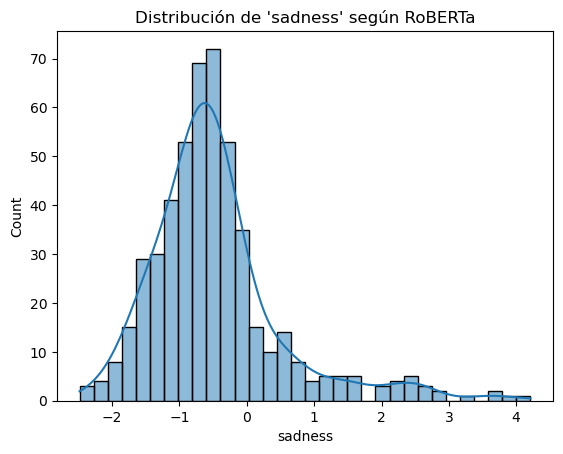

In [10]:
sns.histplot(moods["sadness"], kde=True)
plt.title("Distribución de 'sadness' según RoBERTa")
plt.show()